In [247]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [248]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [249]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# multilayer perceptron 
given any consecutive 3 letters of a name, what is the next letter?

In [250]:
block_size = 3 # context length
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size # [0,0,0]
    for ch in w + '.':
        ix = stoi[ch]
        Y.append(ix)
        X.append(context)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [251]:
emb = C[X]

In [252]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [253]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [254]:
embed_dims = 2


# embed into a lower-dimensional space
C = torch.randn(27, embed_dims)

print(C[1])
print(C[2])

print(C[[1,2]]) # we can index multiple slices using a list

tensor([ 1.0787, -0.2378])
tensor([-0.5419,  0.5163])
tensor([[ 1.0787, -0.2378],
        [-0.5419,  0.5163]])


In [255]:
index = torch.zeros(1,2, dtype=int)
index[0][1] = 1
index[0][0] = 2
print(index)
# we can also so multidimensional slices
C[index]

tensor([[2, 1]])


tensor([[[-0.5419,  0.5163],
         [ 1.0787, -0.2378]]])

In [256]:
# actually convert the words into their embeddings
C[X].shape

torch.Size([32, 3, 2])

In [257]:
X[13, 2] # middle number-for-char of 13th word

tensor(1)

In [258]:
C[X][13,2] # get the token for the middle caracter of the 13th word

tensor([ 1.0787, -0.2378])

In [259]:
# verify
C[1]

tensor([ 1.0787, -0.2378])

In [260]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [261]:
# we have data in the form [token], [token], [token]
# where token is [number, number, number]
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [262]:
# inefficient flatten method
# flatten the three tokens [A,B, C] into [a,a,b,b,c,c]
# current structure:[  (dim1-column)
# [[aa],[bb],[cc]]
# [[aa],[bb],[cc]]
# ...
# [[aa],[bb],[cc]]
#]
# Goal:[
# [aabbcc]
# [aabbcc]
# ...
# [aabbcc]
#]

# achieve by: for each element in dim1, concatenate
# ie concat along dim2
# end shape: (32,6)

torch.unbind(emb, 1)
# this returns data in the format:
# (
# [[aa], [aa], [aa], ..., [aa]] -> this dimension is which word
# [[bb], [bb], [bb], ..., [bb]] -> this dimension is which word
# [[cc], [cc], [cc], ..., [cc]] -> this dimension is which word
# )

# now we need to call cat. 
# if we concatenated along dimension 0 (default), we would just
# make something like [[aa][aa]...[bb][bb]...[cc][cc]]
# this wouldn't be separated into words.
# instead we want to concatenate along dimension 1
# so we get a list of [w1[aabbcc], w2[aabbcc],...]
torch.cat(torch.unbind(emb, 1), 1)



tensor([[-0.0493, -0.4886, -0.0493, -0.4886, -0.0493, -0.4886],
        [-0.0493, -0.4886, -0.0493, -0.4886, -2.4828, -0.3826],
        [-0.0493, -0.4886, -2.4828, -0.3826, -1.7215,  1.2150],
        [-2.4828, -0.3826, -1.7215,  1.2150, -1.7215,  1.2150],
        [-1.7215,  1.2150, -1.7215,  1.2150,  1.0787, -0.2378],
        [-0.0493, -0.4886, -0.0493, -0.4886, -0.0493, -0.4886],
        [-0.0493, -0.4886, -0.0493, -0.4886, -1.3835, -1.0959],
        [-0.0493, -0.4886, -1.3835, -1.0959, -0.1514, -0.2125],
        [-1.3835, -1.0959, -0.1514, -0.2125, -0.7072, -0.6312],
        [-0.1514, -0.2125, -0.7072, -0.6312,  0.1454, -0.5118],
        [-0.7072, -0.6312,  0.1454, -0.5118, -0.7072, -0.6312],
        [ 0.1454, -0.5118, -0.7072, -0.6312,  1.0787, -0.2378],
        [-0.0493, -0.4886, -0.0493, -0.4886, -0.0493, -0.4886],
        [-0.0493, -0.4886, -0.0493, -0.4886,  1.0787, -0.2378],
        [-0.0493, -0.4886,  1.0787, -0.2378,  0.1454, -0.5118],
        [ 1.0787, -0.2378,  0.1454, -0.5

In [263]:
a = torch.arange(18)
a # [0,1,2,...]
a.view(2,9) # [[0-8], [9-17]]
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [264]:
a.storage() # everythin is a 1d tensor, view just changes how we see it


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [265]:
# more efficient way to flatten
print(emb.shape)

torch.Size([32, 3, 2])


In [266]:
# real conv layer
W1 = torch.randn((6,100))
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #-1 means infer size
h.shape # hidden layers

torch.Size([32, 100])

In [267]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [268]:
logits = (h @ W2 + b2)

In [269]:
logits.shape

torch.Size([32, 27])

In [270]:
counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)

In [271]:
prob[0].sum()

tensor(1.0000)

In [272]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [273]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(13.1137)

# More Respectable :)

In [274]:
block_size = 3 # context length
X, Y = [], []

for w in words:
    context = [0] * block_size # [0,0,0]
    for ch in w + '.':
        ix = stoi[ch]
        Y.append(ix)
        X.append(context)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [275]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [276]:
C = torch.randn((27,2)) # letters to embeddings
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

In [277]:
sum(p.nelement() for p in parameters) # number of parameters

3481

In [278]:
for p in parameters:
    p.requires_grad = True

In [279]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # exponential spacing (idk why)

In [280]:
lri =[]
lossi = []

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0,X.shape[0],(32,)) #32 integers that index into dataset


    # forward pass
    emb = C[X[ix]] # embed to tokens (32, 3, 2). Only use minibatch
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #(32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # shortcut for commented code above. Use minibatch added too

    # backward pass
    for p in parameters:
        p.grad= None

    loss.backward()
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track learning rate stats
    # lri.append(lr)
    # lossi.append(loss.item())

print(loss.item())

2.431138038635254


In [281]:
# plt.plot(lre, lossi)# .1 is a good leaerning rate

In [282]:

emb = C[X] # embed to tokens (32, 3, 2). Only use minibatch
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #(32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y) # shortcut for commented code above. Use minibatch added too
print(loss.item())

2.5307815074920654


In [283]:
# now let's generate some names
def generate():
    context = torch.tensor([0,0,0])
    out = []
    for _ in range(10):
        # get the last 3 characters of the context
        contextview = context.view(1,3)
        emb = C[context]
        h = torch.tanh(emb.view(1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, 1)
        nextchar = torch.multinomial(prob, 1).item()
        if nextchar == 0: break
        out.append(nextchar)
        context = torch.cat([context[1:], torch.tensor([nextchar])])
    return ''.join(itos[i] for i in out)


for _ in range(10):
    print(generate())

oyacesahay
mrorloa
aofle
bmenrerc
jjikaa
drcinhunie
jien
late
than
sea


# More Scientific Code

In [284]:
# training split, dev/validation split, test split
# 80%, 10%, 10%


In [288]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [286]:
block_size = 4 # context length
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size # [0,0,0]
    for ch in w + '.':
        ix = stoi[ch]
        Y.append(ix)
        X.append(context)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
.... ---> e
...e ---> m
..em ---> m
.emm ---> a
emma ---> .
olivia
.... ---> o
...o ---> l
..ol ---> i
.oli ---> v
oliv ---> i
livi ---> a
ivia ---> .
ava
.... ---> a
...a ---> v
..av ---> a
.ava ---> .
isabella
.... ---> i
...i ---> s
..is ---> a
.isa ---> b
isab ---> e
sabe ---> l
abel ---> l
bell ---> a
ella ---> .
sophia
.... ---> s
...s ---> o
..so ---> p
.sop ---> h
soph ---> i
ophi ---> a
phia ---> .


In [287]:
def build_dataset(words):
    block_size = 4 # context length
    X, Y = [], []
    for w in words:
        context = [0] * block_size # [0,0,0]
        for ch in w + '.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



In [289]:
C = torch.randn((27,10)) # letters to embeddings
W1 = torch.randn((40, 170))
b1 = torch.randn(170)
W2 = torch.randn((170, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

In [290]:
for p in parameters:
    p.requires_grad = True

In [291]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # exponential spacing (idk why)

In [292]:
lri = []
lossi = []
stepi = []

In [307]:

for i in range(100000):
    
        # minibatch construct
        ix = torch.randint(0,Xtr.shape[0],(32,)) #32 integers that index into dataset
    
    
        # forward pass
        emb = C[Xtr[ix]] # embed to tokens (32, 3, 2). Only use minibatch
        h = torch.tanh(emb.view(-1, 40) @ W1 + b1) #(32, 100)
        logits = h @ W2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Ytr[ix]) # shortcut for commented code above. Use minibatch added too
    
        # backward pass
        for p in parameters:
            p.grad= None
    
        loss.backward()
        # update
        lr = 0.01
        for p in parameters:
            p.data += -lr * p.grad
    
        # track learning rate stats
        # lri.append(lr)
        lossi.append(loss.log10().item())
        stepi.append(i)

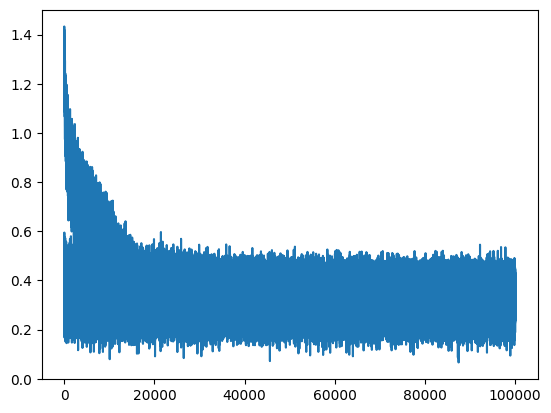

In [308]:
plt.plot(stepi, lossi)

In [309]:
print(loss.item())

1.8625669479370117


In [310]:
# evaluate on dev set
emb = C[Xdev] # embed devset to tokens
print(emb.shape)
h = torch.tanh(emb.view(-1, 40) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())



torch.Size([22655, 4, 10])
2.101008892059326


In [237]:
# only works with 2d vectors
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):# for each letter
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center')
# plt.grid('minor')


In [317]:
# now let's generate some names
def generate():
    context = torch.tensor([0,0,0,0])
    out = []
    for _ in range(10):
        # get the last 4 characters of the context
        contextview = context.view(1,4)
        emb = C[context]
        h = torch.tanh(emb.view(1, 40) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, 1)
        nextchar = torch.multinomial(prob, 1).item()
        if nextchar == 0: break
        out.append(nextchar)
        context = torch.cat([context[1:], torch.tensor([nextchar])])
    return ''.join(itos[i] for i in out)


for _ in range(10):
    print(generate())

ainaldyn
zalie
yaya
elle
marial
zomi
vildi
kerp
styn
yeshaides
